In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/BA_2000_3_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_12_1 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 1
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_12_1[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 26.006251335144043 
    loop_MC 1 - time has passed: 87.47165322303772 
    loop_MC 2 - time has passed: 150.01553106307983 
    loop_MC 3 - time has passed: 201.40385365486145 
    loop_MC 4 - time has passed: 267.7663278579712 
    loop_MC 5 - time has passed: 334.25722575187683 
    loop_MC 6 - time has passed: 384.04211497306824 
    loop_MC 7 - time has passed: 435.8979694843292 
    loop_MC 8 - time has passed: 478.8017258644104 
    loop_MC 9 - time has passed: 541.9837915897369 
    loop_MC 10 - time has passed: 601.3844392299652 
    loop_MC 11 - time has passed: 666.3495075702667 
    loop_MC 12 - time has passed: 723.3777279853821 
    loop_MC 13 - time has passed: 782.9663286209106 
    loop_MC 14 - time has passed: 840.1888942718506 
    loop_MC 15 - time has passed: 901.7412984371185 
    loop_MC 16 - time has passed: 956.200118303299 
    loop_MC 17 - time has passed: 1022.0852942466736 
    loop_MC 18 - time has passed: 1067.975320577621

    loop_MC 2 - time has passed: 164.18819880485535 
    loop_MC 3 - time has passed: 216.09110307693481 
    loop_MC 4 - time has passed: 286.95501470565796 
    loop_MC 5 - time has passed: 343.39709758758545 
    loop_MC 6 - time has passed: 408.43382716178894 
    loop_MC 7 - time has passed: 477.1221978664398 
    loop_MC 8 - time has passed: 522.9124691486359 
    loop_MC 9 - time has passed: 582.434999704361 
    loop_MC 10 - time has passed: 651.3155245780945 
    loop_MC 11 - time has passed: 698.2441234588623 
    loop_MC 12 - time has passed: 754.7714517116547 
    loop_MC 13 - time has passed: 811.9255335330963 
    loop_MC 14 - time has passed: 871.2614579200745 
    loop_MC 15 - time has passed: 920.3505907058716 
    loop_MC 16 - time has passed: 984.1577868461609 
    loop_MC 17 - time has passed: 1037.713035583496 
    loop_MC 18 - time has passed: 1098.6030440330505 
    loop_MC 19 - time has passed: 1159.856097459793 
    loop_MC 20 - time has passed: 1215.4579410552

    loop_MC 4 - time has passed: 290.40461921691895 
    loop_MC 5 - time has passed: 348.33697748184204 
    loop_MC 6 - time has passed: 411.389199256897 
    loop_MC 7 - time has passed: 469.49758982658386 
    loop_MC 8 - time has passed: 527.0039892196655 
    loop_MC 9 - time has passed: 582.317419052124 
    loop_MC 10 - time has passed: 633.7959787845612 
    loop_MC 11 - time has passed: 689.1351592540741 
    loop_MC 12 - time has passed: 743.4432127475739 
    loop_MC 13 - time has passed: 800.0076773166656 
    loop_MC 14 - time has passed: 853.294356584549 
    loop_MC 15 - time has passed: 923.2855875492096 
    loop_MC 16 - time has passed: 974.0346171855927 
    loop_MC 17 - time has passed: 1024.1794211864471 
    loop_MC 18 - time has passed: 1082.167552471161 
    loop_MC 19 - time has passed: 1147.4591705799103 
    loop_MC 20 - time has passed: 1213.4628539085388 
    loop_MC 21 - time has passed: 1271.7220616340637 
    loop_MC 22 - time has passed: 1325.341155529

    loop_MC 6 - time has passed: 371.8815989494324 
    loop_MC 7 - time has passed: 429.74129128456116 
    loop_MC 8 - time has passed: 483.4707679748535 
    loop_MC 9 - time has passed: 540.408406496048 
    loop_MC 10 - time has passed: 585.3596043586731 
    loop_MC 11 - time has passed: 643.5595057010651 
    loop_MC 12 - time has passed: 697.3273801803589 
    loop_MC 13 - time has passed: 746.6916770935059 
    loop_MC 14 - time has passed: 812.826544046402 
    loop_MC 15 - time has passed: 879.8049166202545 
    loop_MC 16 - time has passed: 935.7017455101013 
    loop_MC 17 - time has passed: 987.4943163394928 
    loop_MC 18 - time has passed: 1034.677146911621 
    loop_MC 19 - time has passed: 1098.3927581310272 
    loop_MC 20 - time has passed: 1151.6794505119324 
    loop_MC 21 - time has passed: 1200.4917483329773 
    loop_MC 22 - time has passed: 1266.1683576107025 
    loop_MC 23 - time has passed: 1323.747231245041 
    loop_MC 24 - time has passed: 1387.43324947

    loop_MC 7 - time has passed: 425.55473947525024 
    loop_MC 8 - time has passed: 492.1669681072235 
    loop_MC 9 - time has passed: 544.570698261261 
    loop_MC 10 - time has passed: 603.0393574237823 
    loop_MC 11 - time has passed: 652.6813039779663 
    loop_MC 12 - time has passed: 705.3870458602905 
    loop_MC 13 - time has passed: 753.4493606090546 
    loop_MC 14 - time has passed: 822.0418963432312 
    loop_MC 15 - time has passed: 887.9898011684418 
    loop_MC 16 - time has passed: 934.9502334594727 
    loop_MC 17 - time has passed: 987.0089492797852 
    loop_MC 18 - time has passed: 1052.3783812522888 
    loop_MC 19 - time has passed: 1105.0637147426605 
    loop_MC 20 - time has passed: 1160.2534096240997 
    loop_MC 21 - time has passed: 1217.6108994483948 
    loop_MC 22 - time has passed: 1271.3277089595795 
    loop_MC 23 - time has passed: 1325.6569998264313 
    loop_MC 24 - time has passed: 1388.2692534923553 
    loop_MC 25 - time has passed: 1445.531

    loop_MC 8 - time has passed: 485.1622529029846 
    loop_MC 9 - time has passed: 552.2894384860992 
    loop_MC 10 - time has passed: 602.8799290657043 
    loop_MC 11 - time has passed: 668.6963255405426 
    loop_MC 12 - time has passed: 734.4244101047516 
    loop_MC 13 - time has passed: 796.7931039333344 
    loop_MC 14 - time has passed: 862.9168770313263 
    loop_MC 15 - time has passed: 913.3917620182037 
    loop_MC 16 - time has passed: 975.2864463329315 
    loop_MC 17 - time has passed: 1030.9537959098816 
    loop_MC 18 - time has passed: 1090.2374782562256 
    loop_MC 19 - time has passed: 1148.5398070812225 
    loop_MC 20 - time has passed: 1215.6552929878235 
    loop_MC 21 - time has passed: 1269.3335945606232 
    loop_MC 22 - time has passed: 1332.195814371109 
    loop_MC 23 - time has passed: 1390.2027757167816 
    loop_MC 24 - time has passed: 1435.3992221355438 
    loop_MC 25 - time has passed: 1485.5047647953033 
    loop_MC 26 - time has passed: 1535.7

    loop_MC 10 - time has passed: 616.2931892871857 
    loop_MC 11 - time has passed: 670.314975976944 
    loop_MC 12 - time has passed: 717.7419800758362 
    loop_MC 13 - time has passed: 783.4647061824799 
    loop_MC 14 - time has passed: 837.9166250228882 
    loop_MC 15 - time has passed: 887.2661356925964 
    loop_MC 16 - time has passed: 953.546336889267 
    loop_MC 17 - time has passed: 1001.6758615970612 
    loop_MC 18 - time has passed: 1047.0307881832123 
    loop_MC 19 - time has passed: 1102.4828855991364 
    loop_MC 20 - time has passed: 1161.987651348114 
    loop_MC 21 - time has passed: 1226.2933371067047 
    loop_MC 22 - time has passed: 1289.9492390155792 
    loop_MC 23 - time has passed: 1350.9714624881744 
    loop_MC 24 - time has passed: 1397.3093798160553 
    loop_MC 25 - time has passed: 1455.0396440029144 
    loop_MC 26 - time has passed: 1509.6195905208588 
    loop_MC 27 - time has passed: 1563.1575071811676 
    loop_MC 28 - time has passed: 1624

    loop_MC 12 - time has passed: 736.0669271945953 
    loop_MC 13 - time has passed: 794.8076658248901 
    loop_MC 14 - time has passed: 851.2564532756805 
    loop_MC 15 - time has passed: 906.197612285614 
    loop_MC 16 - time has passed: 957.2809731960297 
    loop_MC 17 - time has passed: 1015.4939088821411 
    loop_MC 18 - time has passed: 1074.758145570755 
    loop_MC 19 - time has passed: 1131.4113636016846 
    loop_MC 20 - time has passed: 1179.2996139526367 
    loop_MC 21 - time has passed: 1234.5777282714844 
    loop_MC 22 - time has passed: 1281.7489507198334 
    loop_MC 23 - time has passed: 1343.965026140213 
    loop_MC 24 - time has passed: 1401.9489207267761 
    loop_MC 25 - time has passed: 1462.3539099693298 
    loop_MC 26 - time has passed: 1519.3381321430206 
    loop_MC 27 - time has passed: 1567.6846766471863 
    loop_MC 28 - time has passed: 1620.7957742214203 
    loop_MC 29 - time has passed: 1672.757246017456 
    loop_MC 30 - time has passed: 173

    loop_MC 14 - time has passed: 886.1187400817871 
    loop_MC 15 - time has passed: 939.2908082008362 
    loop_MC 16 - time has passed: 992.534526348114 
    loop_MC 17 - time has passed: 1045.8328511714935 
    loop_MC 18 - time has passed: 1105.2438070774078 
    loop_MC 19 - time has passed: 1163.714327096939 
    loop_MC 20 - time has passed: 1211.860876083374 
    loop_MC 21 - time has passed: 1268.3841774463654 
    loop_MC 22 - time has passed: 1338.288537979126 
    loop_MC 23 - time has passed: 1394.6711192131042 
    loop_MC 24 - time has passed: 1441.8073003292084 
    loop_MC 25 - time has passed: 1510.575427055359 
    loop_MC 26 - time has passed: 1556.4923906326294 
    loop_MC 27 - time has passed: 1618.083502292633 
    loop_MC 28 - time has passed: 1683.0116708278656 
    loop_MC 29 - time has passed: 1748.7669749259949 
    loop_MC 30 - time has passed: 1805.1129322052002 
    loop_MC 31 - time has passed: 1868.0624105930328 
    loop_MC 32 - time has passed: 191

    loop_MC 16 - time has passed: 965.363872051239 
    loop_MC 17 - time has passed: 1014.4213137626648 
    loop_MC 18 - time has passed: 1077.246256828308 
    loop_MC 19 - time has passed: 1129.3608417510986 
    loop_MC 20 - time has passed: 1183.571121931076 
    loop_MC 21 - time has passed: 1248.6551403999329 
    loop_MC 22 - time has passed: 1299.734576702118 
    loop_MC 23 - time has passed: 1359.4291806221008 
    loop_MC 24 - time has passed: 1425.6546852588654 
    loop_MC 25 - time has passed: 1487.224848985672 
    loop_MC 26 - time has passed: 1535.6938633918762 
    loop_MC 27 - time has passed: 1594.2091219425201 
    loop_MC 28 - time has passed: 1638.6301395893097 
    loop_MC 29 - time has passed: 1706.0942013263702 
    loop_MC 30 - time has passed: 1766.3720741271973 
    loop_MC 31 - time has passed: 1820.054631948471 
    loop_MC 32 - time has passed: 1870.568743467331 
    loop_MC 33 - time has passed: 1924.9330620765686 
    loop_MC 34 - time has passed: 19

    loop_MC 18 - time has passed: 1067.2585663795471 
    loop_MC 19 - time has passed: 1118.3393318653107 
    loop_MC 20 - time has passed: 1174.4780640602112 
    loop_MC 21 - time has passed: 1222.1048793792725 
    loop_MC 22 - time has passed: 1280.6330440044403 
    loop_MC 23 - time has passed: 1332.7204077243805 
    loop_MC 24 - time has passed: 1386.8698976039886 
    loop_MC 25 - time has passed: 1435.4364922046661 
    loop_MC 26 - time has passed: 1497.1986026763916 
    loop_MC 27 - time has passed: 1558.4592838287354 
    loop_MC 28 - time has passed: 1612.9533624649048 
    loop_MC 29 - time has passed: 1671.3307046890259 
    loop_MC 30 - time has passed: 1717.8394227027893 
    loop_MC 31 - time has passed: 1778.0957679748535 
    loop_MC 32 - time has passed: 1828.5109713077545 
    loop_MC 33 - time has passed: 1894.0486686229706 
    loop_MC 34 - time has passed: 1951.0716216564178 
    loop_MC 35 - time has passed: 1996.4967126846313 
    loop_MC 36 - time has pa

    loop_MC 20 - time has passed: 1115.4104924201965 
    loop_MC 21 - time has passed: 1177.7263569831848 
    loop_MC 22 - time has passed: 1235.279296875 
    loop_MC 23 - time has passed: 1292.2440643310547 
    loop_MC 24 - time has passed: 1352.5596890449524 
    loop_MC 25 - time has passed: 1398.0636773109436 
    loop_MC 26 - time has passed: 1442.6186473369598 
    loop_MC 27 - time has passed: 1494.8241426944733 
    loop_MC 28 - time has passed: 1540.01167678833 
    loop_MC 29 - time has passed: 1602.481158733368 
    loop_MC 30 - time has passed: 1657.3763842582703 
    loop_MC 31 - time has passed: 1714.823587179184 
    loop_MC 32 - time has passed: 1764.3610939979553 
    loop_MC 33 - time has passed: 1812.2431991100311 
    loop_MC 34 - time has passed: 1864.9901061058044 
    loop_MC 35 - time has passed: 1913.3658113479614 
    loop_MC 36 - time has passed: 1965.1072764396667 
    loop_MC 37 - time has passed: 2022.4258875846863 
    loop_MC 38 - time has passed: 20

    loop_MC 22 - time has passed: 1286.2725677490234 
    loop_MC 23 - time has passed: 1340.90904712677 
    loop_MC 24 - time has passed: 1386.0898973941803 
    loop_MC 25 - time has passed: 1450.02814245224 
    loop_MC 26 - time has passed: 1497.729868888855 
    loop_MC 27 - time has passed: 1545.4075381755829 
    loop_MC 28 - time has passed: 1589.1157176494598 
    loop_MC 29 - time has passed: 1645.2188379764557 
    loop_MC 30 - time has passed: 1693.6029734611511 
    loop_MC 31 - time has passed: 1739.6547605991364 
    loop_MC 32 - time has passed: 1788.839738368988 
    loop_MC 33 - time has passed: 1835.0477931499481 
    loop_MC 34 - time has passed: 1887.329948425293 
    loop_MC 35 - time has passed: 1939.1027030944824 
    loop_MC 36 - time has passed: 1988.3194961547852 
    loop_MC 37 - time has passed: 2043.9434733390808 
    loop_MC 38 - time has passed: 2107.72487449646 
    loop_MC 39 - time has passed: 2165.0724415779114 
    loop_MC 40 - time has passed: 223

    loop_MC 24 - time has passed: 1244.4545867443085 
    loop_MC 25 - time has passed: 1296.9852085113525 
    loop_MC 26 - time has passed: 1348.697600364685 
    loop_MC 27 - time has passed: 1400.0537757873535 
    loop_MC 28 - time has passed: 1451.5294778347015 
    loop_MC 29 - time has passed: 1502.6483170986176 
    loop_MC 30 - time has passed: 1553.1417834758759 
    loop_MC 31 - time has passed: 1599.1613337993622 
    loop_MC 32 - time has passed: 1650.5746111869812 
    loop_MC 33 - time has passed: 1698.549468755722 
    loop_MC 34 - time has passed: 1753.2099468708038 
    loop_MC 35 - time has passed: 1801.26424574852 
    loop_MC 36 - time has passed: 1854.7632973194122 
    loop_MC 37 - time has passed: 1904.0153529644012 
    loop_MC 38 - time has passed: 1954.6119298934937 
    loop_MC 39 - time has passed: 2004.0488967895508 
    loop_MC 40 - time has passed: 2057.6595933437347 
    loop_MC 41 - time has passed: 2107.2589604854584 
    loop_MC 42 - time has passed

    loop_MC 26 - time has passed: 1307.632096529007 
    loop_MC 27 - time has passed: 1354.3107678890228 
    loop_MC 28 - time has passed: 1404.5227699279785 
    loop_MC 29 - time has passed: 1457.665352344513 
    loop_MC 30 - time has passed: 1502.3089969158173 
    loop_MC 31 - time has passed: 1546.1185321807861 
    loop_MC 32 - time has passed: 1590.170013666153 
    loop_MC 33 - time has passed: 1634.3878057003021 
    loop_MC 34 - time has passed: 1678.1700983047485 
    loop_MC 35 - time has passed: 1722.2108252048492 
    loop_MC 36 - time has passed: 1766.2150347232819 
    loop_MC 37 - time has passed: 1811.3687241077423 
    loop_MC 38 - time has passed: 1855.8655271530151 
    loop_MC 39 - time has passed: 1901.085756778717 
    loop_MC 40 - time has passed: 1946.7846422195435 
    loop_MC 41 - time has passed: 1990.5334644317627 
    loop_MC 42 - time has passed: 2034.562168121338 
    loop_MC 43 - time has passed: 2078.0648641586304 
    loop_MC 44 - time has passed:

    loop_MC 28 - time has passed: 1284.9601514339447 
    loop_MC 29 - time has passed: 1329.9812009334564 
    loop_MC 30 - time has passed: 1374.3925833702087 
    loop_MC 31 - time has passed: 1418.9318764209747 
    loop_MC 32 - time has passed: 1463.1112253665924 
    loop_MC 33 - time has passed: 1507.364028930664 
    loop_MC 34 - time has passed: 1550.7886035442352 
    loop_MC 35 - time has passed: 1595.4098672866821 
    loop_MC 36 - time has passed: 1640.9799761772156 
    loop_MC 37 - time has passed: 1685.0693926811218 
    loop_MC 38 - time has passed: 1729.2894279956818 
    loop_MC 39 - time has passed: 1773.0061123371124 
    loop_MC 40 - time has passed: 1816.8791375160217 
    loop_MC 41 - time has passed: 1861.147673368454 
    loop_MC 42 - time has passed: 1906.218145608902 
    loop_MC 43 - time has passed: 1949.243914604187 
    loop_MC 44 - time has passed: 1988.207766532898 
    loop_MC 45 - time has passed: 2026.1847608089447 
    loop_MC 46 - time has passed:

In [6]:
print(i_beta_12_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


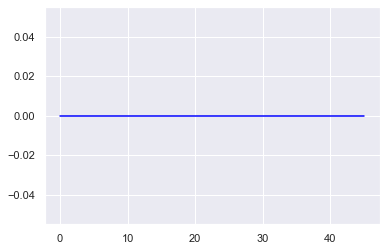

In [7]:
plt.plot(i_beta_12_1, color='blue')

In [8]:
scio.savemat('./i_beta_12_1.mat', {'i_beta_12_1': i_beta_12_1})